In [1]:
# Example of simple model load and evaluate

# ===============LICENSE_START=======================================================
# Apache-2.0
# ===================================================================================
# Copyright (C) 2019 AT&T Intellectual Property  All rights reserved.
# ===================================================================================
# This software file is distributed by AT&T
# under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# http://www.apache.org/licenses/LICENSE-2.0
#
# This file is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ===============LICENSE_END=========================================================


In [2]:
import numpy as np
import pandas as pd
import os,sys,shutil  # file checks
import dill as pickle   # serialize functions and data as compressed binary 
import gzip  # compression 
import yaml   # configuration file
import time  # time tracking

from acumos.wrapped import load_model

import util_call
import util_review

# load our configuration
config_path = 'config.yaml'
if not os.path.isfile(config_path):
    print("Sorry, can't find the configuration file {}, aborting.".format(config_path))
    sys.exit(-1)
config = yaml.safe_load(open(config_path))

# Load Raw Data
Load the raw test data and double-check the schema of the data with a random sample.

In [3]:
## PART 1 - load and start a local model runner 
# https://pypi.org/project/acumos/#using-dataframes-with-scikit-learn

# read our larger datasets as binary files
with gzip.open(config["path"]["etl"], 'rb') as f:
    df = pickle.load(f)
print(df["X_test"].columns)
print(df["X_test"].sample(1).transpose())

Index(['helpful', 'reviewText', 'summary', 'unixReviewTime', 'categories',
       'description'],
      dtype='object')
                                                             3990
helpful                                                    [0, 1]
reviewText      I've always eyed wrist rests in the stores and...
summary         Didn't think I needed it, but now I can't live...
unixReviewTime                                         1287446400
categories      [office products, office & school supplies, de...
description     The 3M Gel Wrist Rest helps to alleviate the a...


# Check wrapped model
Load the wrapped model and test it with a single (simulated sample)

In [4]:
# load model from disk, see that it is a nicely "wrapped" model
wrapped_model = load_model(os.path.join('data', config["publish"]["name_model2"]))
print(wrapped_model)

In [5]:
# actual evaluation code...

# test 1 - take an example of our own sample (where we can see format from the model)
data_in = [[[0,0], "I've had better", "not much", int(time.time()), ["office products"], "rubbery item"]]
print("[TEST] Samples to process {}...".format(len(data_in)))
list_result = util_call.score_model(wrapped_model, data_in, False)


[TEST] Samples to process 1...
Evaluation time for 1 items, 0.220 sec


# Check Test Data
Now we'll quickly process a random subset of test data through the whole ETL and prediction.  Afterwards, we'll plot the performance on this subset.

In [6]:
# test 2 - evaluate our test data

# read our larger datasets as binary files
with gzip.open(config["path"]["etl"], 'rb') as f:
    df = pickle.load(f)
num_test = 100
data_in = df["X_test"].sample(num_test)
df_label = df["y_test"].loc[data_in.index]
print("[EVALUATE] Samples to process {}...".format(len(data_in)))
list_result = util_call.score_model(wrapped_model, data_in.values.tolist(), False)
df_predict = pd.DataFrame(list_result)


[EVALUATE] Samples to process 100...
Evaluation time for 100 items, 15.446 sec


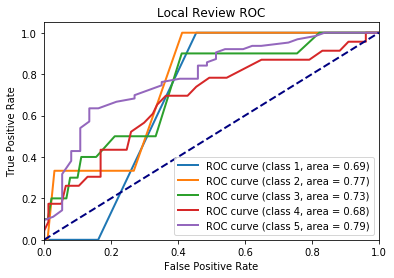

rf AUC: 0.899 (100 samples)


In [7]:
# print(df_predict)
# print(df_label)
auc_class = util_review.draw_roc(None, df_label, df_predict.values, title="Local Review ROC")
print("{} AUC: {:0.3f} ({} samples)".format(config["training"]["model_type"], auc_class, num_test))
